In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import njit
import statsmodels.api as sm

In [2]:
@njit
def f(z, μ, Σ):
    """
    The density function of multivariate normal distribution.

    Parameters
    ---------------
    z: ndarray(float, dim=2)
        random vector, N by 1
    μ: ndarray(float, dim=1 or 2)
        the mean of z, N by 1
    Σ: ndarray(float, dim=2)
        the covarianece matrix of z, N by 1
    """

    z = np.atleast_2d(z)
    μ = np.atleast_2d(μ)
    Σ = np.atleast_2d(Σ)

    N = z.size

    temp1 = np.linalg.det(Σ) ** (-1/2)
    temp2 = np.exp(-.5 * (z - μ).T @ np.linalg.inv(Σ) @ (z - μ))

    return (2 * np.pi) ** (-N/2) * temp1 * temp2

In [3]:
class MultivariateNormal:
    """
    Class of multivariate normal distribution.

    Parameters
    ----------
    μ: ndarray(float, dim=1)
        the mean of z, N by 1
    Σ: ndarray(float, dim=2)
        the covarianece matrix of z, N by 1

    Arguments
    ---------
    μ, Σ:
        see parameters
    μs: list(ndarray(float, dim=1))
        list of mean vectors μ1 and μ2 in order
    Σs: list(list(ndarray(float, dim=2)))
        2 dimensional list of covariance matrices
        Σ11, Σ12, Σ21, Σ22 in order
    βs: list(ndarray(float, dim=1))
        list of regression coefficients β1 and β2 in order
    """

    def __init__(self, μ, Σ):
        "initialization"
        self.μ = np.array(μ)
        self.Σ = np.atleast_2d(Σ)

    def partition(self, k):
        """
        Given k, partition the random vector z into a size k vector z1
        and a size N-k vector z2. Partition the mean vector μ into
        μ1 and μ2, and the covariance matrix Σ into Σ11, Σ12, Σ21, Σ22
        correspondingly. Compute the regression coefficients β1 and β2
        using the partitioned arrays.
        """
        μ = self.μ
        Σ = self.Σ

        self.μs = [μ[:k], μ[k:]]
        self.Σs = [[Σ[:k, :k], Σ[:k, k:]],
                   [Σ[k:, :k], Σ[k:, k:]]]

        self.βs = [self.Σs[0][1] @ np.linalg.inv(self.Σs[1][1]),
                   self.Σs[1][0] @ np.linalg.inv(self.Σs[0][0])]

    def cond_dist(self, ind, z):
        """
        Compute the conditional distribution of z1 given z2, or reversely.
        Argument ind determines whether we compute the conditional
        distribution of z1 (ind=0) or z2 (ind=1).

        Returns
        ---------
        μ_hat: ndarray(float, ndim=1)
            The conditional mean of z1 or z2.
        Σ_hat: ndarray(float, ndim=2)
            The conditional covariance matrix of z1 or z2.
        """
        β = self.βs[ind]
        μs = self.μs
        Σs = self.Σs

        μ_hat = μs[ind] + β @ (z - μs[1-ind])
        Σ_hat = Σs[ind][ind] - β @ Σs[1-ind][1-ind] @ β.T

        return μ_hat, Σ_hat

In [4]:
μ = np.array([.5, 1.])
Σ = np.array([[1., .5], [.5 ,1.]])

# construction of the multivariate normal instance
multi_normal = MultivariateNormal(μ, Σ)

In [5]:
k = 1 # choose partition

# partition and compute regression coefficients
multi_normal.partition(k)
multi_normal.βs[0],multi_normal.βs[1]

(array([[0.5]]), array([[0.5]]))

In [6]:
beta = multi_normal.βs 

a1 = μ[0] - beta[0]*μ[1]
b1 = beta[0]

a2 = μ[1] - beta[1]*μ[0]
b2 = beta[1]

In [7]:
print ("a1 = ", a1)
print ("b1 = ", b1)

a1 =  [[0.]]
b1 =  [[0.5]]


In [8]:
print ("a2 = ", a2)
print ("b2 = ", b2)

a2 =  [[0.75]]
b2 =  [[0.5]]


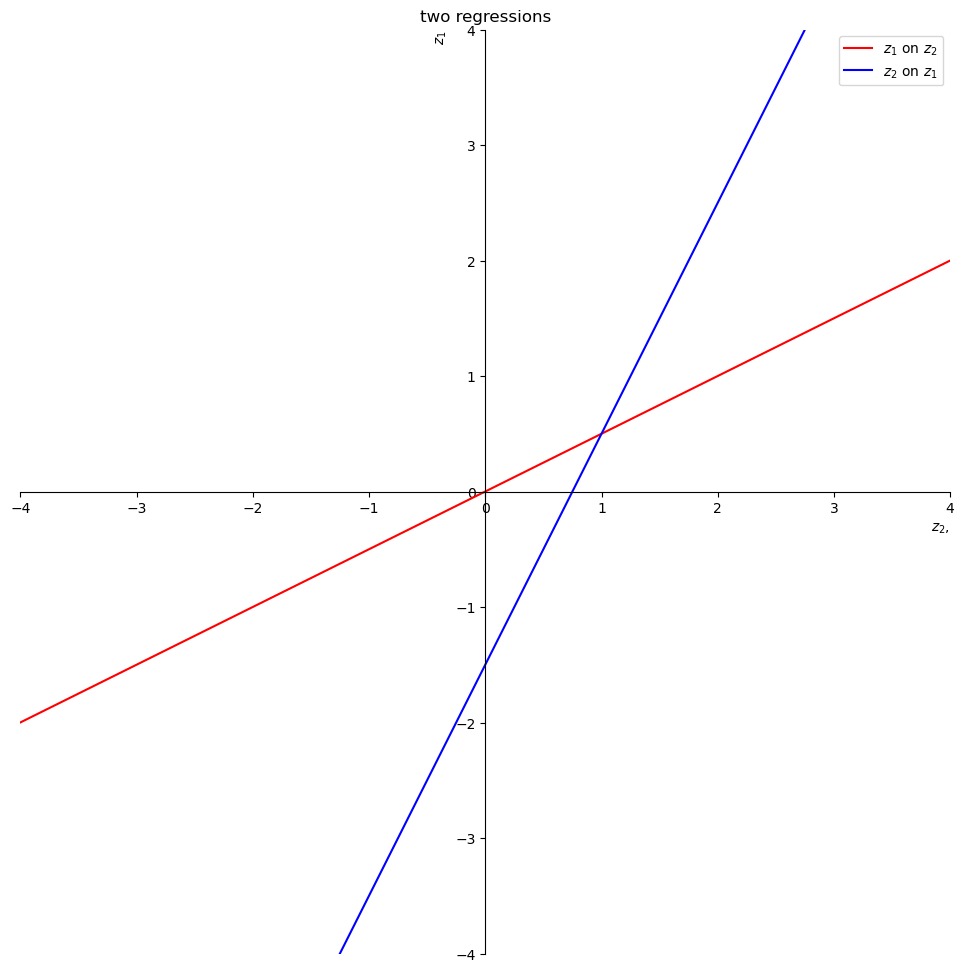

In [9]:
z2 = np.linspace(-4,4,100)


a1 = np.squeeze(a1)
b1 = np.squeeze(b1)

a2 = np.squeeze(a2)
b2 = np.squeeze(b2)

z1  = b1*z2 + a1


z1h = z2/b2 - a2/b2


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
ax.set(xlim=(-4, 4), ylim=(-4, 4))
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.ylabel('$z_1$', loc = 'top')
plt.xlabel('$z_2$,', loc = 'right')
plt.title('two regressions')
plt.plot(z2,z1, 'r', label = "$z_1$ on $z_2$")
plt.plot(z2,z1h, 'b', label = "$z_2$ on $z_1$")
plt.legend()
plt.show()

In [10]:
print("a1 = ", a1)
print("b1 = ", b1)

a1 =  0.0
b1 =  0.5


In [11]:
print("-a2/b2 = ", - a2/b2)
print("1/b2 = ", 1/b2)

-a2/b2 =  -1.5
1/b2 =  2.0


In [12]:
# compute the cond. dist. of z1
ind = 1
z1 = np.array([5.]) # given z1

μ2_hat, Σ2_hat = multi_normal.cond_dist(ind, z1)
print('μ2_hat, Σ2_hat = ', μ2_hat, Σ2_hat)

μ2_hat, Σ2_hat =  [3.25] [[0.75]]


In [13]:
# compute the cond. dist. of z1
ind = 0
z2 = np.array([5.]) # given z2

μ1_hat, Σ1_hat = multi_normal.cond_dist(ind, z2)
print('μ1_hat, Σ1_hat = ', μ1_hat, Σ1_hat)

μ1_hat, Σ1_hat =  [2.5] [[0.75]]


In [14]:
n = 1_000_000 # sample size

# simulate multivariate normal random vectors
data = np.random.multivariate_normal(μ, Σ, size=n)
z1_data = data[:, 0]
z2_data = data[:, 1]

# OLS regression
μ1, μ2 = multi_normal.μs
results = sm.OLS(z1_data - μ1, z2_data - μ2).fit()

In [15]:
multi_normal.βs[0], results.params

(array([[0.5]]), array([0.50047034]))

In [16]:
Σ1_hat, results.resid @ results.resid.T / (n - 1)

(array([[0.75]]), 0.7512214541245483)

In [17]:
μ1_hat, results.predict(z2 - μ2) + μ1

(array([2.5]), array([2.50188135]))

In [18]:
μ = np.random.random(3)
C = np.random.random((3, 3))
Σ = C @ C.T # positive semi-definite

multi_normal = MultivariateNormal(μ, Σ)

In [19]:
μ, Σ

(array([0.98687957, 0.11410278, 0.24043583]),
 array([[1.47537092, 1.41429285, 1.01959834],
        [1.41429285, 1.67994108, 1.02252289],
        [1.01959834, 1.02252289, 1.00136225]]))

In [20]:
k = 1
multi_normal.partition(k)

In [21]:
ind = 0
z2 = np.array([2., 5.])

μ1_hat, Σ1_hat = multi_normal.cond_dist(ind, z2)

In [22]:
n = 1_000_000
data = np.random.multivariate_normal(μ, Σ, size=n)
z1_data = data[:, :k]
z2_data = data[:, k:]

In [23]:
μ1, μ2 = multi_normal.μs
results = sm.OLS(z1_data - μ1, z2_data - μ2).fit()

In [24]:
multi_normal.βs[0], results.params

(array([[0.58688646, 0.41892282]]), array([0.58662191, 0.41857035]))

In [25]:
Σ1_hat, results.resid @ results.resid.T / (n - 1)

(array([[0.21820858]]), 0.21839606356486133)

In [26]:
μ1_hat, results.predict(z2 - μ2) + μ1

(array([4.08757716]), array([4.08540063]))

In [27]:
def construct_moments_IQ(n, μθ, σθ, σy):

    μ_IQ = np.full(n+1, μθ)

    D_IQ = np.zeros((n+1, n+1))
    D_IQ[range(n), range(n)] = σy
    D_IQ[:, n] = σθ

    Σ_IQ = D_IQ @ D_IQ.T

    return μ_IQ, Σ_IQ, D_IQ

In [28]:
n = 50
μθ, σθ, σy = 100., 10., 10.

μ_IQ, Σ_IQ, D_IQ = construct_moments_IQ(n, μθ, σθ, σy)
μ_IQ, Σ_IQ, D_IQ

(array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100.]),
 array([[200., 100., 100., ..., 100., 100., 100.],
        [100., 200., 100., ..., 100., 100., 100.],
        [100., 100., 200., ..., 100., 100., 100.],
        ...,
        [100., 100., 100., ..., 200., 100., 100.],
        [100., 100., 100., ..., 100., 200., 100.],
        [100., 100., 100., ..., 100., 100., 100.]]),
 array([[10.,  0.,  0., ...,  0.,  0., 10.],
        [ 0., 10.,  0., ...,  0.,  0., 10.],
        [ 0.,  0., 10., ...,  0.,  0., 10.],
        ...,
        [ 0.,  0.,  0., ..., 10.,  0., 10.],
        [ 0.,  0.,  0., ...,  0., 10., 10.],
        [ 0.,  0.,  0., ...,  0.,  0., 10.]]))

In [29]:
multi_normal_IQ = MultivariateNormal(μ_IQ, Σ_IQ)

k = n
multi_normal_IQ.partition(k)

In [30]:
x = np.random.multivariate_normal(μ_IQ, Σ_IQ)
y = x[:-1] # test scores
θ = x[-1]  # IQ

In [31]:
# the true value
θ

107.2554052488007

In [32]:
ind = 1
multi_normal_IQ.cond_dist(ind, y)

(array([106.21883334]), array([[1.96078431]]))

In [33]:
# array for containing moments
μθ_hat_arr = np.empty(n)
Σθ_hat_arr = np.empty(n)

# loop over number of test scores
for i in range(1, n+1):
    # construction of multivariate normal distribution instance
    μ_IQ_i, Σ_IQ_i, D_IQ_i = construct_moments_IQ(i, μθ, σθ, σy)
    multi_normal_IQ_i = MultivariateNormal(μ_IQ_i, Σ_IQ_i)

    # partition and compute conditional distribution
    multi_normal_IQ_i.partition(i)
    scores_i = y[:i]
    μθ_hat_i, Σθ_hat_i = multi_normal_IQ_i.cond_dist(1, scores_i)

    # store the results
    μθ_hat_arr[i-1] = μθ_hat_i[0]
    Σθ_hat_arr[i-1] = Σθ_hat_i[0, 0]

# transform variance to standard deviation
σθ_hat_arr = np.sqrt(Σθ_hat_arr)

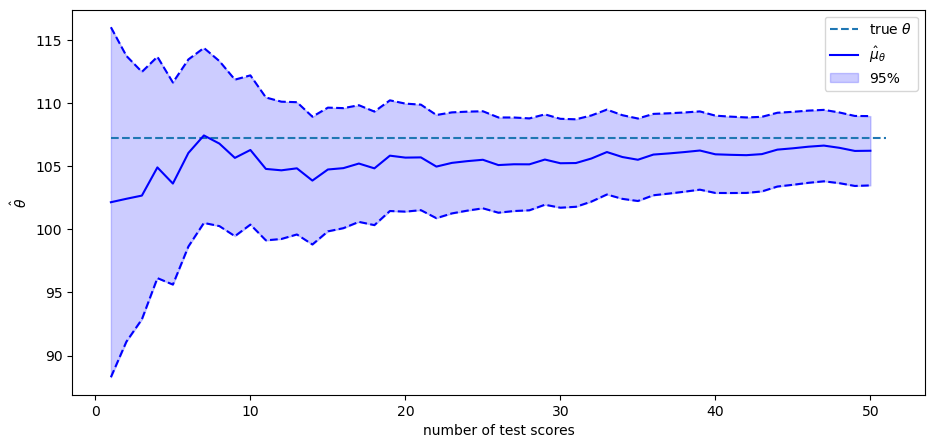

In [34]:
μθ_hat_lower = μθ_hat_arr - 1.96 * σθ_hat_arr
μθ_hat_higher = μθ_hat_arr + 1.96 * σθ_hat_arr

plt.hlines(θ, 1, n+1, ls='--', label='true $θ$')
plt.plot(range(1, n+1), μθ_hat_arr, color='b', label='$\hat{μ}_{θ}$')
plt.plot(range(1, n+1), μθ_hat_lower, color='b', ls='--')
plt.plot(range(1, n+1), μθ_hat_higher, color='b', ls='--')
plt.fill_between(range(1, n+1), μθ_hat_lower, μθ_hat_higher,
                 color='b', alpha=0.2, label='95%')

plt.xlabel('number of test scores')
plt.ylabel('$\hat{θ}$')
plt.legend()

plt.show()

In [35]:
C = np.linalg.cholesky(Σ_IQ)
G = np.linalg.inv(C)

ε = G @ (x - μθ)

In [36]:
cε = C[n, :] * ε

# compute the sequence of μθ and Σθ conditional on y1, y2, ..., yk
μθ_hat_arr_C = np.array([np.sum(cε[:k+1]) for k in range(n)]) + μθ
Σθ_hat_arr_C = np.array([np.sum(C[n, i+1:n+1] ** 2) for i in range(n)])

In [37]:
# conditional mean
np.max(np.abs(μθ_hat_arr - μθ_hat_arr_C)) < 1e-10

True

In [38]:
# conditional variance
np.max(np.abs(Σθ_hat_arr - Σθ_hat_arr_C)) < 1e-10

True

In [39]:
def construct_moments_IQ2d(n, μθ, σθ, μη, ση, σy):

    μ_IQ2d = np.empty(2*(n+1))
    μ_IQ2d[:n] = μθ
    μ_IQ2d[2*n] = μθ
    μ_IQ2d[n:2*n] = μη
    μ_IQ2d[2*n+1] = μη


    D_IQ2d = np.zeros((2*(n+1), 2*(n+1)))
    D_IQ2d[range(2*n), range(2*n)] = σy
    D_IQ2d[:n, 2*n] = σθ
    D_IQ2d[2*n, 2*n] = σθ
    D_IQ2d[n:2*n, 2*n+1] = ση
    D_IQ2d[2*n+1, 2*n+1] = ση

    Σ_IQ2d = D_IQ2d @ D_IQ2d.T

    return μ_IQ2d, Σ_IQ2d, D_IQ2d

In [40]:
n = 2
# mean and variance of θ, η, and y
μθ, σθ, μη, ση, σy = 100., 10., 100., 10, 10

μ_IQ2d, Σ_IQ2d, D_IQ2d = construct_moments_IQ2d(n, μθ, σθ, μη, ση, σy)
μ_IQ2d, Σ_IQ2d, D_IQ2d

(array([100., 100., 100., 100., 100., 100.]),
 array([[200., 100.,   0.,   0., 100.,   0.],
        [100., 200.,   0.,   0., 100.,   0.],
        [  0.,   0., 200., 100.,   0., 100.],
        [  0.,   0., 100., 200.,   0., 100.],
        [100., 100.,   0.,   0., 100.,   0.],
        [  0.,   0., 100., 100.,   0., 100.]]),
 array([[10.,  0.,  0.,  0., 10.,  0.],
        [ 0., 10.,  0.,  0., 10.,  0.],
        [ 0.,  0., 10.,  0.,  0., 10.],
        [ 0.,  0.,  0., 10.,  0., 10.],
        [ 0.,  0.,  0.,  0., 10.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 10.]]))

In [41]:
# take one draw
x = np.random.multivariate_normal(μ_IQ2d, Σ_IQ2d)
y1 = x[:n]
y2 = x[n:2*n]
θ = x[2*n]
η = x[2*n+1]

# the true values
θ, η

(113.56929295623003, 83.87221521842687)

In [42]:
multi_normal_IQ2d = MultivariateNormal(μ_IQ2d, Σ_IQ2d)

k = 2*n # the length of data vector
multi_normal_IQ2d.partition(k)

multi_normal_IQ2d.cond_dist(1, [*y1, *y2])

(array([119.58148161,  87.56805789]),
 array([[33.33333333,  0.        ],
        [ 0.        , 33.33333333]]))

In [43]:
def cond_dist_IQ2d(μ, Σ, data):

    n = len(μ)

    multi_normal = MultivariateNormal(μ, Σ)
    multi_normal.partition(n-1)
    μ_hat, Σ_hat = multi_normal.cond_dist(1, data)

    return μ_hat, Σ_hat

In [44]:
for indices, IQ, conditions in [([*range(2*n), 2*n], 'θ', 'y1, y2, y3, y4'),
                                ([*range(n), 2*n], 'θ', 'y1, y2'),
                                ([*range(n, 2*n), 2*n], 'θ', 'y3, y4'),
                                ([*range(2*n), 2*n+1], 'η', 'y1, y2, y3, y4'),
                                ([*range(n), 2*n+1], 'η', 'y1, y2'),
                                ([*range(n, 2*n), 2*n+1], 'η', 'y3, y4')]:

    μ_hat, Σ_hat = cond_dist_IQ2d(μ_IQ2d[indices], Σ_IQ2d[indices][:, indices], x[indices[:-1]])
    print(f'The mean and variance of {IQ} conditional on {conditions: <15} are ' +
          f'{μ_hat[0]:1.2f} and {Σ_hat[0, 0]:1.2f} respectively')

The mean and variance of θ conditional on y1, y2, y3, y4  are 119.58 and 33.33 respectively
The mean and variance of θ conditional on y1, y2          are 119.58 and 33.33 respectively
The mean and variance of θ conditional on y3, y4          are 100.00 and 100.00 respectively
The mean and variance of η conditional on y1, y2, y3, y4  are 87.57 and 33.33 respectively
The mean and variance of η conditional on y1, y2          are 100.00 and 100.00 respectively
The mean and variance of η conditional on y3, y4          are 87.57 and 33.33 respectively


In [45]:
# as an example, consider the case where T = 3
T = 3

In [46]:
# variance of the initial distribution x_0
σ0 = 1.

# parameters of the equation system
a = .9
b = 1.
c = 1.0
d = .05

In [47]:
# construct the covariance matrix of X
Σx = np.empty((T+1, T+1))

Σx[0, 0] = σ0 ** 2
for i in range(T):
    Σx[i, i+1:] = Σx[i, i] * a ** np.arange(1, T+1-i)
    Σx[i+1:, i] = Σx[i, i+1:]

    Σx[i+1, i+1] = a ** 2 * Σx[i, i] + b ** 2

In [48]:
Σx

array([[1.      , 0.9     , 0.81    , 0.729   ],
       [0.9     , 1.81    , 1.629   , 1.4661  ],
       [0.81    , 1.629   , 2.4661  , 2.21949 ],
       [0.729   , 1.4661  , 2.21949 , 2.997541]])

In [49]:
# construct the covariance matrix of Y
C = np.eye(T+1) * c
D = np.eye(T+1) * d

Σy = C @ Σx @ C.T + D @ D.T

In [50]:
# construct the covariance matrix of Z
Σz = np.empty((2*(T+1), 2*(T+1)))

Σz[:T+1, :T+1] = Σx
Σz[:T+1, T+1:] = Σx @ C.T
Σz[T+1:, :T+1] = C @ Σx
Σz[T+1:, T+1:] = Σy

In [51]:
Σz

array([[1.      , 0.9     , 0.81    , 0.729   , 1.      , 0.9     ,
        0.81    , 0.729   ],
       [0.9     , 1.81    , 1.629   , 1.4661  , 0.9     , 1.81    ,
        1.629   , 1.4661  ],
       [0.81    , 1.629   , 2.4661  , 2.21949 , 0.81    , 1.629   ,
        2.4661  , 2.21949 ],
       [0.729   , 1.4661  , 2.21949 , 2.997541, 0.729   , 1.4661  ,
        2.21949 , 2.997541],
       [1.      , 0.9     , 0.81    , 0.729   , 1.0025  , 0.9     ,
        0.81    , 0.729   ],
       [0.9     , 1.81    , 1.629   , 1.4661  , 0.9     , 1.8125  ,
        1.629   , 1.4661  ],
       [0.81    , 1.629   , 2.4661  , 2.21949 , 0.81    , 1.629   ,
        2.4686  , 2.21949 ],
       [0.729   , 1.4661  , 2.21949 , 2.997541, 0.729   , 1.4661  ,
        2.21949 , 3.000041]])

In [52]:
# construct the mean vector of Z
μz = np.zeros(2*(T+1))

In [53]:
z = np.random.multivariate_normal(μz, Σz)

x = z[:T+1]
y = z[T+1:]

In [54]:
# construct a MultivariateNormal instance
multi_normal_ex1 = MultivariateNormal(μz, Σz)
x = z[:T+1]
y = z[T+1:]

In [55]:
# partition Z into X and Y
multi_normal_ex1.partition(T+1)

In [56]:
# compute the conditional mean and covariance matrix of X given Y=y

print("X = ", x)
print("Y = ", y)
print(" E [ X | Y] = ", )

multi_normal_ex1.cond_dist(0, y)

X =  [0.29025927 0.70230104 1.0772114  1.5059603 ]
Y =  [0.32548463 0.71756503 1.17022404 1.59904789]
 E [ X | Y] = 


(array([0.32562596, 0.71768299, 1.17013875, 1.59768648]),
 array([[2.48875094e-03, 5.57449314e-06, 1.24861718e-08, 2.80231394e-11],
        [5.57449314e-06, 2.48876343e-03, 5.57452116e-06, 1.25113937e-08],
        [1.24861718e-08, 5.57452116e-06, 2.48876346e-03, 5.58575339e-06],
        [2.80232504e-11, 1.25113935e-08, 5.58575339e-06, 2.49377812e-03]]))

In [57]:
t = 3

In [58]:
# mean of the subvector
sub_μz = np.zeros(t+1)

# covariance matrix of the subvector
sub_Σz = np.empty((t+1, t+1))

sub_Σz[0, 0] = Σz[t, t] # x_t
sub_Σz[0, 1:] = Σz[t, T+1:T+t+1]
sub_Σz[1:, 0] = Σz[T+1:T+t+1, t]
sub_Σz[1:, 1:] = Σz[T+1:T+t+1, T+1:T+t+1]

In [59]:
sub_Σz

array([[2.997541, 0.729   , 1.4661  , 2.21949 ],
       [0.729   , 1.0025  , 0.9     , 0.81    ],
       [1.4661  , 0.9     , 1.8125  , 1.629   ],
       [2.21949 , 0.81    , 1.629   , 2.4686  ]])

In [60]:
multi_normal_ex2 = MultivariateNormal(sub_μz, sub_Σz)
multi_normal_ex2.partition(1)

In [61]:
sub_y = y[:t]

multi_normal_ex2.cond_dist(0, sub_y)

(array([1.05202488]), array([[1.00201996]]))

In [62]:
t = 3
j = 2

In [63]:
sub_μz = np.zeros(t-j+2)
sub_Σz = np.empty((t-j+2, t-j+2))

sub_Σz[0, 0] = Σz[T+t+1, T+t+1]
sub_Σz[0, 1:] = Σz[T+t+1, T+1:T+t-j+2]
sub_Σz[1:, 0] = Σz[T+1:T+t-j+2, T+t+1]
sub_Σz[1:, 1:] = Σz[T+1:T+t-j+2, T+1:T+t-j+2]

In [64]:
sub_Σz

array([[3.000041, 0.729   , 1.4661  ],
       [0.729   , 1.0025  , 0.9     ],
       [1.4661  , 0.9     , 1.8125  ]])

In [65]:
multi_normal_ex3 = MultivariateNormal(sub_μz, sub_Σz)
multi_normal_ex3.partition(1)

In [66]:
sub_y = y[:t-j+1]

multi_normal_ex3.cond_dist(0, sub_y)

(array([0.5803702]), array([[1.81413617]]))

In [67]:
H = np.linalg.cholesky(Σy)

H

array([[1.00124922, 0.        , 0.        , 0.        ],
       [0.8988771 , 1.00225743, 0.        , 0.        ],
       [0.80898939, 0.89978675, 1.00225743, 0.        ],
       [0.72809046, 0.80980808, 0.89978676, 1.00225743]])

In [68]:
ε = np.linalg.inv(H) @ y

ε

array([0.32507854, 0.42440132, 0.52418495, 0.54579092])

In [69]:
y

array([0.32548463, 0.71756503, 1.17022404, 1.59904789])

In [70]:
# set parameters
T = 80
T = 160
# coefficients of the second order difference equation
𝛼0 = 10
𝛼1 = 1.53
𝛼2 = -.9

# variance of u
σu = 1.
σu = 10.

# distribution of y_{-1} and y_{0}
μy_tilde = np.array([1., 0.5])
Σy_tilde = np.array([[2., 1.], [1., 0.5]])

In [71]:
# construct A and A^{\prime}
A = np.zeros((T, T))

for i in range(T):
    A[i, i] = 1

    if i-1 >= 0:
        A[i, i-1] = -𝛼1

    if i-2 >= 0:
        A[i, i-2] = -𝛼2

A_inv = np.linalg.inv(A)

In [72]:
# compute the mean vectors of b and y
μb = np.full(T, 𝛼0)
μb[0] += 𝛼1 * μy_tilde[1] + 𝛼2 * μy_tilde[0]
μb[1] += 𝛼2 * μy_tilde[1]

μy = A_inv @ μb

In [73]:
# compute the covariance matrices of b and y
Σu = np.eye(T) * σu ** 2

Σb = np.zeros((T, T))

C = np.array([[𝛼2, 𝛼1], [0, 𝛼2]])
Σb[:2, :2] = C @ Σy_tilde @ C.T

Σy = A_inv @ (Σb + Σu) @ A_inv.T

In [74]:
β = .96

In [75]:
# construct B
B = np.zeros((T, T))

for i in range(T):
    B[i, i:] = β ** np.arange(0, T-i)

In [76]:
D = np.vstack([np.eye(T), B])

In [77]:
μz = D @ μy
Σz = D @ Σy @ D.T

In [78]:
z = np.random.multivariate_normal(μz, Σz)
y, p = z[:T], z[T:]

In [79]:
cond_Ep = np.empty(T-1)

sub_μ = np.empty(3)
sub_Σ = np.empty((3, 3))
for t in range(2, T+1):
    sub_μ[:] = μz[[t-2, t-1, T-1+t]]
    sub_Σ[:, :] = Σz[[t-2, t-1, T-1+t], :][:, [t-2, t-1, T-1+t]]

    multi_normal = MultivariateNormal(sub_μ, sub_Σ)
    multi_normal.partition(2)

    cond_Ep[t-2] = multi_normal.cond_dist(1, y[t-2:t])[0][0]

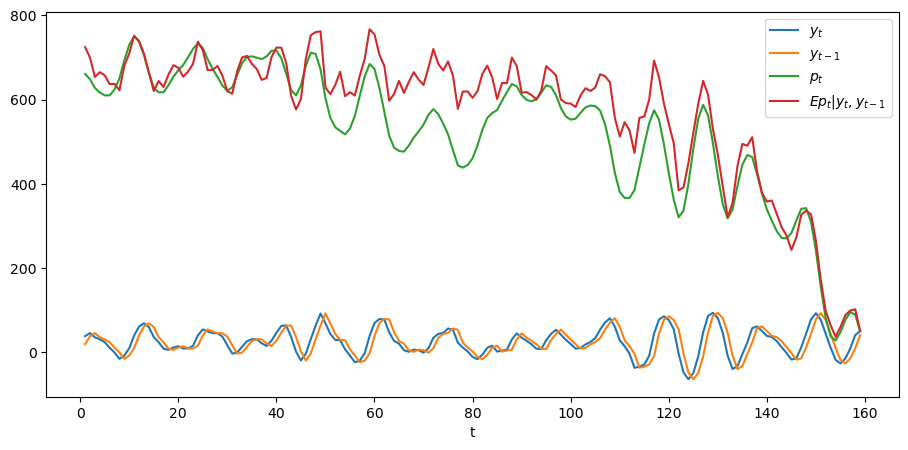

In [80]:
plt.plot(range(1, T), y[1:], label='$y_{t}$')
plt.plot(range(1, T), y[:-1], label='$y_{t-1}$')
plt.plot(range(1, T), p[1:], label='$p_{t}$')
plt.plot(range(1, T), cond_Ep, label='$Ep_{t}|y_{t}, y_{t-1}$')

plt.xlabel('t')
plt.legend(loc=1)
plt.show()

In [81]:
G = np.array([[1., 3.]])
R = np.array([[1.]])

x0_hat = np.array([0., 1.])
Σ0 = np.array([[1., .5], [.3, 2.]])

μ = np.hstack([x0_hat, G @ x0_hat])
Σ = np.block([[Σ0, Σ0 @ G.T], [G @ Σ0, G @ Σ0 @ G.T + R]])

In [82]:
# construction of the multivariate normal instance
multi_normal = MultivariateNormal(μ, Σ)

In [83]:
multi_normal.partition(2)

In [84]:
# the observation of y
y0 = 2.3

# conditional distribution of x0
μ1_hat, Σ11 = multi_normal.cond_dist(0, y0)
μ1_hat, Σ11

(array([-0.078125,  0.803125]),
 array([[ 0.72098214, -0.203125  ],
        [-0.403125  ,  0.228125  ]]))

In [85]:
A = np.array([[0.5, 0.2], [-0.1, 0.3]])
C = np.array([[2.], [1.]])

# conditional distribution of x1
x1_cond = A @ μ1_hat
Σ1_cond = C @ C.T + A @ Σ11 @ A.T
x1_cond, Σ1_cond

(array([0.1215625, 0.24875  ]),
 array([[4.12874554, 1.95523214],
        [1.92123214, 1.04592857]]))

In [86]:
def iterate(x0_hat, Σ0, A, C, G, R, y_seq):

    p, n = G.shape

    T = len(y_seq)
    x_hat_seq = np.empty((T+1, n))
    Σ_hat_seq = np.empty((T+1, n, n))

    x_hat_seq[0] = x0_hat
    Σ_hat_seq[0] = Σ0

    for t in range(T):
        xt_hat = x_hat_seq[t]
        Σt = Σ_hat_seq[t]
        μ = np.hstack([xt_hat, G @ xt_hat])
        Σ = np.block([[Σt, Σt @ G.T], [G @ Σt, G @ Σt @ G.T + R]])

        # filtering
        multi_normal = MultivariateNormal(μ, Σ)
        multi_normal.partition(n)
        x_tilde, Σ_tilde = multi_normal.cond_dist(0, y_seq[t])

        # forecasting
        x_hat_seq[t+1] = A @ x_tilde
        Σ_hat_seq[t+1] = C @ C.T + A @ Σ_tilde @ A.T

    return x_hat_seq, Σ_hat_seq

In [87]:
iterate(x0_hat, Σ0, A, C, G, R, [2.3, 1.2, 3.2])

(array([[0.        , 1.        ],
        [0.1215625 , 0.24875   ],
        [0.18680212, 0.06904689],
        [0.75576875, 0.05558463]]),
 array([[[1.        , 0.5       ],
         [0.3       , 2.        ]],
 
        [[4.12874554, 1.95523214],
         [1.92123214, 1.04592857]],
 
        [[4.08198663, 1.99218488],
         [1.98640488, 1.00886423]],
 
        [[4.06457628, 2.00041999],
         [1.99943739, 1.00275526]]]))

In [88]:
N = 10
k = 2

In [89]:
Λ = np.zeros((N, k))
Λ[:N//2, 0] = 1
Λ[N//2:, 1] = 1

σu = .5
D = np.eye(N) * σu ** 2

In [90]:
# compute Σy
Σy = Λ @ Λ.T + D

In [91]:
μz = np.zeros(k+N)

Σz = np.empty((k+N, k+N))

Σz[:k, :k] = np.eye(k)
Σz[:k, k:] = Λ.T
Σz[k:, :k] = Λ
Σz[k:, k:] = Σy

In [92]:
z = np.random.multivariate_normal(μz, Σz)

f = z[:k]
y = z[k:]

In [93]:
multi_normal_factor = MultivariateNormal(μz, Σz)
multi_normal_factor.partition(k)

In [94]:
multi_normal_factor.cond_dist(0, y)

(array([0.33303933, 1.60199065]),
 array([[0.04761905, 0.        ],
        [0.        , 0.04761905]]))

In [95]:
B = Λ.T @ np.linalg.inv(Σy)

B @ y

array([0.33303933, 1.60199065])

In [96]:
multi_normal_factor.cond_dist(1, f)

(array([0.30771784, 0.30771784, 0.30771784, 0.30771784, 0.30771784,
        1.42701043, 1.42701043, 1.42701043, 1.42701043, 1.42701043]),
 array([[0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25]]))

In [97]:
Λ @ f

array([0.30771784, 0.30771784, 0.30771784, 0.30771784, 0.30771784,
       1.42701043, 1.42701043, 1.42701043, 1.42701043, 1.42701043])

In [98]:
𝜆_tilde, P = np.linalg.eigh(Σy)

# arrange the eigenvectors by eigenvalues
ind = sorted(range(N), key=lambda x: 𝜆_tilde[x], reverse=True)

P = P[:, ind]
𝜆_tilde = 𝜆_tilde[ind]
Λ_tilde = np.diag(𝜆_tilde)

print('𝜆_tilde =', 𝜆_tilde)

𝜆_tilde = [5.25 5.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]


In [99]:
# verify the orthogonality of eigenvectors
np.abs(P @ P.T - np.eye(N)).max()

4.440892098500626e-16

In [100]:
# verify the eigenvalue decomposition is correct
P @ Λ_tilde @ P.T

array([[1.25, 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.25, 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.25, 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.25, 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 1.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.25, 1.  , 1.  , 1.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.25, 1.  , 1.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.25, 1.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.25, 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.25]])

In [101]:
ε = P.T @ y

print("ε = ", ε)

ε =  [ 3.76126799  0.78193352 -0.34445602 -0.28389907  0.08150635 -0.12942721
  0.31955534  0.24253848  0.45712392  0.34348855]


In [102]:
# print the values of the two factors

print('f = ', f)

f =  [0.30771784 1.42701043]


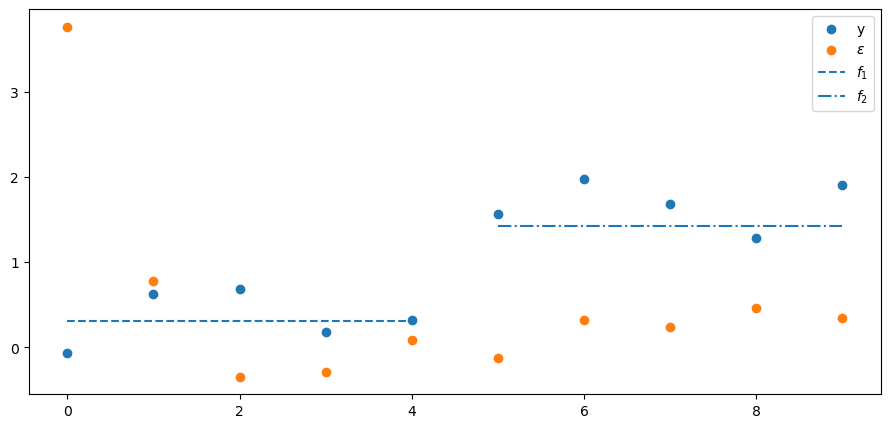

In [103]:
plt.scatter(range(N), y, label='y')
plt.scatter(range(N), ε, label='$\epsilon$')
plt.hlines(f[0], 0, N//2-1, ls='--', label='$f_{1}$')
plt.hlines(f[1], N//2, N-1, ls='-.', label='$f_{2}$')
plt.legend()

plt.show()

In [104]:
ε[:2]

array([3.76126799, 0.78193352])

In [105]:
# compare with Ef|y
B @ y

array([0.33303933, 1.60199065])

In [106]:
𝜆_tilde[:2].sum() / 𝜆_tilde.sum()

0.8400000000000002

In [107]:
y_hat = P[:, :2] @ ε[:2]

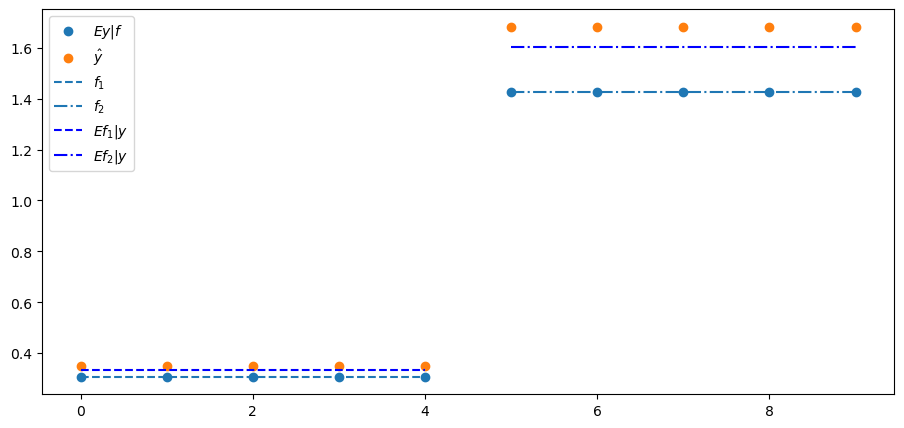

In [108]:
plt.scatter(range(N), Λ @ f, label='$Ey|f$')
plt.scatter(range(N), y_hat, label='$\hat{y}$')
plt.hlines(f[0], 0, N//2-1, ls='--', label='$f_{1}$')
plt.hlines(f[1], N//2, N-1, ls='-.', label='$f_{2}$')

Efy = B @ y
plt.hlines(Efy[0], 0, N//2-1, ls='--', color='b', label='$Ef_{1}|y$')
plt.hlines(Efy[1], N//2, N-1, ls='-.', color='b', label='$Ef_{2}|y$')
plt.legend()

plt.show()

In [109]:
Σεjk = (P.T @ Σy @ P)[:2, :2]

Pjk = P[:, :2]

Σy_hat = Pjk @ Σεjk @ Pjk.T
print('Σy_hat = \n', Σy_hat)

Σy_hat = 
 [[1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]]
